### The purpose of this kernel is to boost your creativity towards feature engineering with Santander's Customer Transaction variables. If it fulfills this purpose, please, consider upvoting the kernel :)

--------------------------

## **Index**:
1. Competition and Data Overview; <br>
2. Defining probability in terms of frequency difference;<br>
&nbsp; &nbsp;2.1\. Building our graph<br>
&nbsp; &nbsp;2.2 Defining the frequency ratio between right and left sides<br>
3. Analysing the type of graphs;<br>
&nbsp; &nbsp;3.1 Regular features<br>
&nbsp; &nbsp;3.2 Reversed features<br>
&nbsp; &nbsp;3.3 Flat features<br>
&nbsp; &nbsp;3.4 Extreme features<br>
4. Feature engineering<br>
&nbsp; &nbsp;4.1 Using frequency ratio as a predictive score<br>
&nbsp; &nbsp;4.2 Separating different populations as a gaussian mixture<br>
5. Summary

### **1) COMPETITION AND DATA OVERVIEW:**

Santander's competition is about predicting which clients are going to make a transfer in the future. The available dataset is split between train and test, with 200,000 clients in each and no missing values. There are 200 variables available (0, 199), but no information about them is given other than the numbers they hold.

As far as we know, all variables are independent from each other to the extent that if we separate the clients that made the transfer from the clients that didn't, then shuffle their values, and put them all back together, __[it won't affect your prediction score](https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/83882)__.

So far, only a few teams were able to cross the 0.902 prediction score barrier. A lot of people tried many different ideas, and almost all of them failed. So, I hope you have fun reading this kernel and that it may help you joining the 0.902 club.

Let's take a quick look at the data:

In [1]:
#import libs
import numpy as np
import pandas as pd 
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skewnorm
from collections import defaultdict


In [2]:
#import data
train_df = pd.read_csv('../input/train.csv')
#test_df = pd.read_csv('../input/test.csv')

In [3]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


### **2) DEFINING PROBABILITY IN TERMS OF FREQUENCY DIFFERENCE**

#### **2.1) BUILDING OUR GRAPH**

Basically on this kernel I would like to show to you how the probability of making a transfer is highly correlated to the difference in frequency between the right and left sides of the distribution.

Let's take a look at the frequency distribution of var_0.

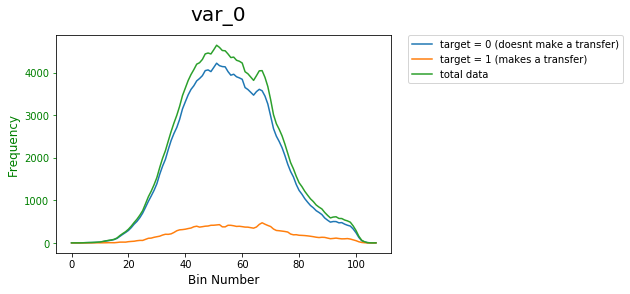

In [4]:
def running_mean(x, N):
   cumsum = np.cumsum(np.insert(x, 0, 0)) 
   return np.concatenate([x[0:N-1], (cumsum[N:] - cumsum[:-N]) / N])

var = 'var_0' #feat we are going to analyse
mydf = train_df.copy() #df we are going to analyze

def df_to_bin(var, mydf):
    IQR = mydf[var].quantile([0.75]).values - mydf[var].quantile([0.25]).values #inter-quartile range
    n = 200000 #size of our dataframe
    bin_size = 2.5*IQR/n**(1/3) #Freedman-Diaconis rule to define the bin size
    bin_number = int((mydf[var].max() - mydf[var].min())/bin_size)

    #creat new feature based on the bins
    mydf['new' + var] = pd.cut(mydf[var], bins = bin_number, labels = range(bin_number)).astype('float')

    #separate dfs betweens target ==0 and target == 1
    df_no_transfer = mydf['new' + var][mydf['target'] == 0].value_counts().sort_index()
    #get the bin frequency height (H) and the index of that bin (X)
    H0,X0 = list(df_no_transfer.values), list(df_no_transfer.index) 

    df_with_transfer = mydf['new' + var][mydf['target'] == 1].value_counts().sort_index()
    H1,X1 = list(df_with_transfer.values), list(df_with_transfer.index) 

    #If there are any bins with 0 frequency between 0 and the total number of bins, lets put it in our list
    for i in range(bin_number):
        if i not in X0:
            H0.append(0)
            X0.append(i)

        if i not in X1:
            H1.append(0)
            X1.append(i)

    #sort the bins so the list index == bin number
    H0 = [h for _,h in sorted(zip(X0,H0))]
    X0 = [x for x,_ in sorted(zip(X0,H0))]
    H1 = [h for _,h in sorted(zip(X1,H1))]
    X1 = [x for x,_ in sorted(zip(X1,H1))]

    H0 = running_mean(H0, 2)  
    H1 = running_mean(H1, 2)  
    Hsum = H0 + H1
    
    return bin_size, bin_number, mydf, H0, H1, Hsum, X0, X1

var = 'var_0'
bin_size, bin_number, mydf, H0, H1, Hsum, X0, X1 = df_to_bin(var, train_df)

#plot the result
fig, ax1 = plt.subplots()
ax1.plot(H0, label='target = 0 (doesnt make a transfer)')
ax1.plot(H1, label='target = 1 (makes a transfer)')
ax1.plot(Hsum, label='total data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.suptitle(var, fontsize=20)
ax1.set_ylabel('Frequency', color='g', fontsize=12)
ax1.tick_params(axis='y', colors='green')
plt.xlabel('Bin Number', fontsize=12)
plt.show()

- In **<font color=orange>orange</font>** you can see the distribution of the clients that *make* a transfer.
- In **<font color=blue>blue</font>** it is the distribution of the clients that *do not make* a transfer.
- And finally, in **<font color=green>green</font>**, it is the *total* distribution

> #### **2.1) DEFINING THE PROBABILITY OF MAKING A TRANSFER**

Now that we have the frequency distribution, let's take a look at the probability of a client making a transfer on each bin of this distribution.

$$Probabiliy = MakesTransfer / TotalData$$

PS: We will only check probability values where bins have at least 80 data points.

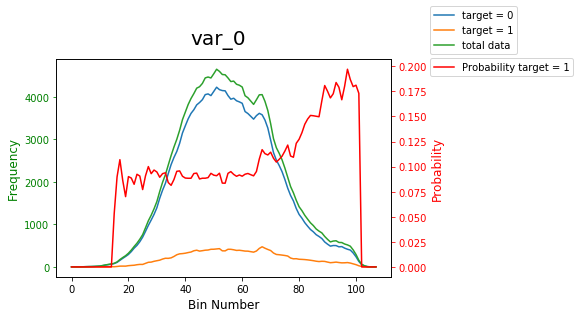

In [5]:
Hmin = 80
def get_probs(bin_number, H1, Hsum, Hmin):
    probs = []
    #finds min_i
    for i in range(bin_number):
        if Hsum[i] > Hmin:
            min_i = i
            break

    #finds max_i
    for i in reversed(range(bin_number)):
        if Hsum[i] > Hmin:
            max_i = i
            break

    #get probabilities to plot
    for i in range(0, bin_number):
        if i < min_i or i > max_i:
            probs.append(0)
        else:
            probs.append(H1[i]/Hsum[i]) 
    
    return probs, min_i, max_i

probs, min_i, max_i = get_probs(bin_number, H1, Hsum, Hmin)

#plot the result
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(H0, label='target = 0')
ax1.plot(H1, label='target = 1')
ax1.plot(Hsum, label='total data')
ax2.plot(probs, 'r', label='Probability target = 1')
ax1.legend(bbox_to_anchor=(1.10, 1), loc=3)
ax2.legend(bbox_to_anchor=(1.10, 0.90), loc=3)
fig.suptitle(var, fontsize=20)
ax1.set_ylabel('Frequency', color='g', fontsize=12)
ax1.tick_params(axis='y', colors='green')
ax2.set_ylabel('Probability', color='r', fontsize=12)
ax2.tick_params(axis='y', colors='red')
ax1.set_xlabel('Bin Number', fontsize=12)
plt.show()

As you can see, in **<font color=red>red</font>**, the probability of making a transfer is around 10% for all the values before bin 60, when it starts raising up to 20%. An important observation is that only 10% of the clients in the whole dataset make a transfer. So if we had to randomly guess who will make a transfer before bin 60, we would have a really good score without using any complex model. 

- Is something happening after bin 60? 
- Is this behavior common?

Let's see!

#### **2.2) DEFINING THE FREQUENCY RATIO BETWEEN RIGHT AND LEFT SIDES**

After plotting a few graphs, it became clear that the side with more "volume" usually has a higher probability. Let's dig deeper.

First, let's define the **center of the distribution** as the line in between the two most "straight sequence" on the sides. To get these sequences, we will have to look at the slope.

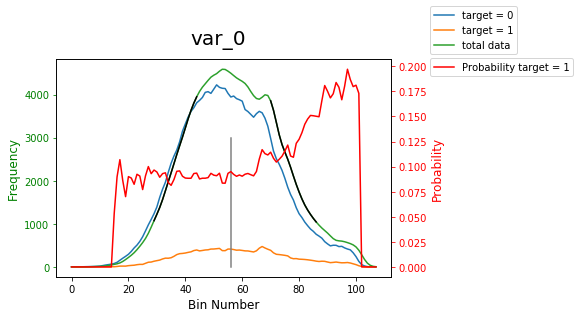

In [6]:
def get_central_point(bin_number, Hsum, H0, H1):

    #finds the slop at each point       
    slope = []
    for i in range(bin_number - 1):

        init = Hsum[i]
        end = Hsum[i+1]
        x = 1
        y = end - init
        slope.append(np.arctan(y/x) * 180/3.1416)

    slope.append(slope[-1]) #last slope is equal to its previous
    slope = np.array(slope)

    #finds the slop difference at each point   
    slopediff = [0]
    for i in range(1, bin_number):
        slopediff.append(np.abs(slope[i] - slope[i-1]))

    #finds two "straight lines" of length 15 on the left and right of the distribution
    min_len = 15
    max_slop_diff = 0.05
    len_max_l = 0
    len_max_r = 0
    count = 0
    #at each iteration, if we don't have the 15 points if max_slop_diff between them,
    #we will lower this difference threshold
    while len_max_l < min_len or len_max_r < min_len:
        count += 1 #if after 5 iterations we dont get those 15 points, we will lower the minimum amount of points
        slope_dict_left = defaultdict(list)
        slope_dict_right = defaultdict(list)
        l, r = 0, 0
        maxl = 0
        maxr = 0

        for i in range(bin_number):
            s = slope[i]
            sd = slopediff[i]
            if s > 0 and sd < max_slop_diff and Hsum[i] > 1000:
                slope_dict_left[l].append(i)
            else:
                l_len = len(slope_dict_left[l])
                if l_len > len(slope_dict_left[maxl]):
                    maxl = l
                l += 1
            if s < 0 and sd < max_slop_diff and Hsum[i] > 1000:
                slope_dict_right[r].append(i)
            else:
                r_len = len(slope_dict_right[r])
                if r_len > len(slope_dict_right[maxr]):
                    maxr = r
                r += 1

        len_max_l = len(slope_dict_left[maxl])
        len_max_r = len(slope_dict_right[maxr])

        #only used if we dont get the 15 points on left and right side
        if count > 5:
            if min_len > 12:
                min_len = min_len*0.9
            max_slop_diff = max_slop_diff*1.1

            H0 = running_mean(H0, 2)
            H1 = running_mean(H1, 2)
            Hsum = H0 + H1

            #finds the slop at each point       
            slope = []
            for i in range(bin_number - 1):

                init = Hsum[i]
                end = Hsum[i+1]
                x = 1
                y = end - init
                slope.append(np.arctan(y/x) * 180/3.1416)
            slope.append(slope[-1])

            slope = np.array(slope)

            slopediff = [0]
            for i in range(1, bin_number):
                slopediff.append(np.abs(slope[i] - slope[i-1]))

        else:
            max_slop_diff = max_slop_diff*1.1

    #select the lines with the highest length
    slope_left = slope_dict_left[maxl]#[int(len_max_l*0.30): int(len_max_l*0.90)]
    slope_right = slope_dict_right[maxr]#[int(len_max_r*0.10): int(len_max_r*0.70)]

    #now lets align their maximum and minimum height H, with a maxium difference of 100
    max_diff = 100

    while Hsum[slope_left[-1]] - Hsum[slope_right[0]] > max_diff:
        slope_left = slope_left[:-2]

    while Hsum[slope_right[0]] - Hsum[slope_left[-1]] > max_diff:
        slope_right = slope_right[1:]

    while Hsum[slope_right[-1]] - Hsum[slope_left[0]] > max_diff:
        slope_left = slope_left[1:]

    while Hsum[slope_left[0]] - Hsum[slope_right[-1]] > +max_diff:
        slope_right = slope_right[:-2]

    #Find the median of the lines
    i_median_left = int(len(slope_left)/2)
    i_median_right = int(len(slope_right)/2)

    #Finds the central point of the distribution based on the this two lines
    l = 0
    r = 0
    H_left = Hsum[slope_left]
    H_right = Hsum[slope_right]
    indexes = []
    if len(slope_left) < len(slope_right):

        for h in H_left:
            indexes.append(np.argmin(np.abs(H_right-h)))

        for index_left, index_right in zip(range(len(slope_left)), indexes):
            l += slope_left[index_left]
            r += slope_right[index_right]

        central_point = np.round((l+r)/(2*(index_left+1)))
    else:
        for h in H_right:
            indexes.append(np.argmin(np.abs(H_left-h)))

        for index_right, index_left in zip(range(len(slope_right)), indexes):
            l += slope_left[index_left]
            r += slope_right[index_right]

        central_point = np.round((l+r)/(2*(index_right+1)))

    central_point = np.round(central_point)
    
    return central_point, Hsum, slope_left, slope_right, i_median_left, i_median_right

central_point, Hsum, slope_left, slope_right, i_median_left, i_median_right = get_central_point(bin_number, Hsum, H0, H1)

#plot the result
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(H0, label='target = 0')
ax1.plot(H1, label='target = 1')
ax1.plot(Hsum, label='total data')
ax1.plot(slope_left, Hsum[slope_left], 'k')
ax1.plot(slope_right, Hsum[slope_right], 'k')
ax1.plot([central_point, central_point], [0,3000], 'grey')
ax2.plot(probs, 'r', label='Probability target = 1')
ax1.legend(bbox_to_anchor=(1.10, 1), loc=3)
ax2.legend(bbox_to_anchor=(1.10, 0.90), loc=3)

ax1.set_ylabel('Frequency', color='g', fontsize=12)
ax1.tick_params(axis='y', colors='green')
ax1.set_xlabel('Bin Number', fontsize=12)

ax2.set_ylabel('Probability', color='r', fontsize=12)
ax2.tick_params(axis='y', colors='red')

fig.suptitle(var, fontsize=20)
plt.xlabel('bin_number', fontsize=12)
plt.show()

If you look at the graph, you will see that we have set as **black** the sides of the distribution, and in **<font color=grey>grey</font>** what we called the central point.

Now lets plot the frequency difference of opposite bins based on this central point. For example: Let's suppose that the central point is on bin 60. 
- On bin 61, the height ratio will be height_bin_61/height_bin_59. 
- On bin 30, the height ratio will be height_bin_30/height_bin_90.

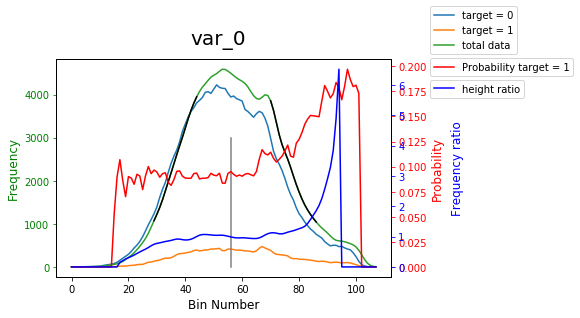

In [7]:
def get_ratio(central_point, bin_number, Hsum, Hmin):

    ratio = []
    len_1st_half = central_point
    len_2nd_half = bin_number - central_point
    i = 0
    if len_1st_half > len_2nd_half:
        index = central_point - len_2nd_half

        while i < index:
            ratio.append(0)
            i += 1

        for i in range(i, bin_number):
            i_end = int(central_point + (central_point - i) - 1)
            if Hsum[i_end] < Hmin or Hsum[i] < Hmin:
                ratio.append(0)
            else:
                ratio.append((Hsum[i])/(Hsum[i_end]))


    else:
        index = central_point - len_2nd_half

        for i in range(i, bin_number):
            i_end = int(central_point + (central_point - i) - 1)
            if i > 2*central_point:
                ratio.append(0)
                continue
            if Hsum[i_end] < Hmin or Hsum[i] < Hmin:
                ratio.append(0)
            else:
                ratio.append((Hsum[i])/(Hsum[i_end]))
            

    return ratio

ratio = get_ratio(central_point, bin_number, Hsum, Hmin)

#plot the result
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax1.plot(H0, label='target = 0')
ax1.plot(H1, label='target = 1')
ax1.plot(Hsum, label='total data')
ax1.plot(slope_left, Hsum[slope_left], 'k')
ax1.plot(slope_right, Hsum[slope_right], 'k')
ax1.plot([central_point, central_point], [0,3000], 'grey')
ax2.plot(probs, 'r', label='Probability target = 1')
ax3.plot(ratio, 'b', label='height ratio')
ax1.legend(bbox_to_anchor=(1.1, 1), loc=3)
ax2.legend(bbox_to_anchor=(1.1, 0.90), loc=3)
ax3.legend(bbox_to_anchor=(1.1, 0.80), loc=3)
fig.suptitle(var, fontsize=20)
ax1.set_ylabel('Frequency', color='g', fontsize=12)
ax1.tick_params(axis='y', colors='green')
ax1.set_xlabel('Bin Number', fontsize=12)

ax2.set_ylabel('Probability', color='r', fontsize=12)
ax2.tick_params(axis='y', colors='red')

ax3.set_ylabel('Frequency ratio', color='b', fontsize=12)
ax3.tick_params(axis='y', colors='blue')
ax3.yaxis.set_label_coords(1.18, 0.5)
plt.show()

The result of this ratio can be notice by the **<font color=blue>blue</font>** line, which shows how many times a bin is higher than its opposite. So, for example, the bin around 90 is 6 times higher/more frequent than the bin around 30. <br>
*Note: the abrupt cut on the end of the blue line is either because there are less than 80 data points on one of the bins being compared, of because it is a division by 0*

It becomes clear that there is a strong correlation between the frequency ratio and the probability of a client making a transfer.

One can hypothesize that, if we know the distribution of our data, maybe we could try to estimate the probability of a client making a transfer based on each variable. But we still haven't answered: Is this behavior common?

### **3) ANALYSING THE TYPES OF GRAPHS**
By analyzing the data, I was able to find basically 4 types of graphs:

**Regular)** In **149** of them, probability positively correlates to height ratio: the side with more volume has a higher probability.

**Reversed**) In **27** of them, probability negatively correlates to height ratio: the side with less volume has a higher probability. <br>
*Note: It might not be a characteristic of the variable itself, but just my algorithm not being perfect and selecting a good central_point*

**Flat)** In **20** of them, the probability is flat or almost flat: the difference in frequency won't or will barely affect the probabilities, which will stay around 10% no matter the value of the variable. <br>
*Note: Those variables seem to be the ones of the least impact in the predictive model.*

**Extremes)** Only **4** of them have a behavior in which the probability increases on both extremities.

Interesting observation: There is not a single feature that has a flat probability distribution followed by a decrease on the extremes. That means that we should focus our efforts on finding characteristics that correlates to target = 1, and not target = 0.

Let's see those graphs below:

In [8]:
#function we will use to plot
def plot_graph(var, df, Hmin):
    bin_size, bin_number, df, H0, H1, Hsum, X0, X1 = df_to_bin(var, train_df)
    probs, min_i, max_i = get_probs(bin_number, H1, Hsum, Hmin)
    central_point, Hsum, slope_left, slope_right, i_median_left, i_median_right = get_central_point(bin_number, Hsum, H0, H1)
    ratio = get_ratio(central_point, bin_number, Hsum, Hmin)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax1.plot(H0, label='target = 0')
    ax1.plot(H1, label='target = 1')
    ax1.plot(Hsum, label='total data')
    ax1.plot(slope_left, Hsum[slope_left], 'k')
    ax1.plot(slope_right, Hsum[slope_right], 'k')
    ax1.plot([central_point, central_point], [0,3000], 'grey')
    ax2.plot(probs, 'r', label='Probability target = 1')
    ax3.plot(ratio, 'b', label='height ratio')
    ax1.legend(bbox_to_anchor=(1.1, 1), loc=3)
    ax2.legend(bbox_to_anchor=(1.1, 0.90), loc=3)
    ax3.legend(bbox_to_anchor=(1.1, 0.80), loc=3)
    
    ax1.set_ylabel('Frequency', color='g', fontsize=12)
    ax1.tick_params(axis='y', colors='green')
    ax1.set_xlabel('Bin Number', fontsize=12)
    
    ax2.set_ylabel('Probability', color='r', fontsize=12)
    ax2.tick_params(axis='y', colors='red')

    ax3.set_ylabel('Frequency ratio', color='b', fontsize=12)
    ax3.tick_params(axis='y', colors='blue')
    ax3.yaxis.set_label_coords(1.18, 0.5)
    
    fig.suptitle(var, fontsize=20)
    plt.xlabel('bin_number', fontsize=12)
    plt.show()
    




### **3.1) REGULAR FEATURES EXAMPLE**

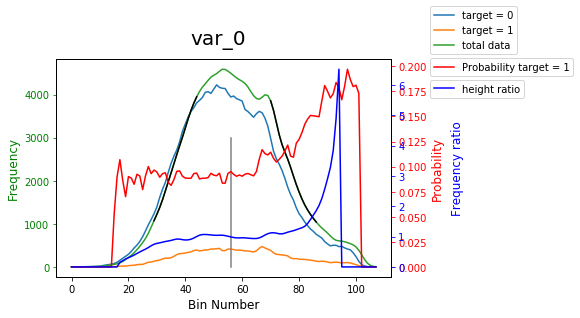

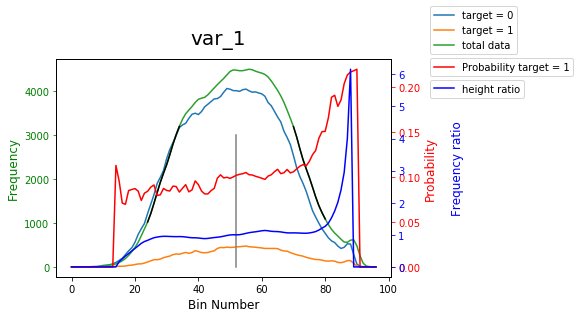

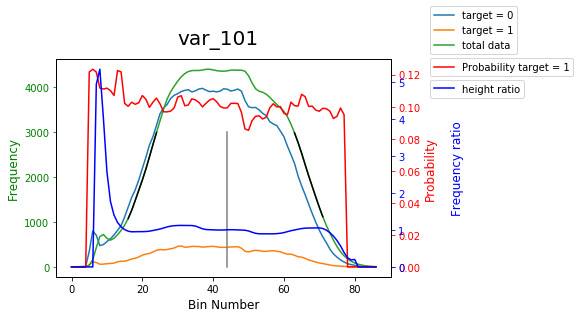

In [9]:
regular_features = ['var_0', 'var_1', 'var_101', 'var_102', 'var_105', 'var_106', 'var_108', 'var_109', 'var_11', 'var_110', 'var_111', 'var_113', 'var_114', 'var_115', 'var_116', 'var_118', 'var_119', 'var_12', 'var_122', 'var_123', 'var_125', 'var_127', 'var_128', 'var_129', 'var_13', 'var_130', 'var_131', 'var_132', 'var_133', 'var_134', 'var_135', 'var_137', 'var_138', 'var_139', 'var_141', 'var_143', 'var_144', 'var_145', 'var_146', 'var_147', 'var_148', 'var_15', 'var_150', 'var_151', 'var_152', 'var_153', 'var_154', 'var_155', 'var_157', 'var_159', 'var_16', 'var_162', 'var_163', 'var_164', 'var_165', 'var_166', 'var_167', 'var_168', 'var_169', 'var_170', 'var_171', 'var_173', 'var_174', 'var_175', 'var_176', 'var_179', 'var_18', 'var_180', 'var_181', 'var_182', 'var_184', 'var_187', 'var_188', 'var_189', 'var_19', 'var_190', 'var_191', 'var_193', 'var_194', 'var_195', 'var_196', 'var_197', 'var_198', 'var_2', 'var_22', 'var_24', 'var_25', 'var_26', 'var_28', 'var_3', 'var_32', 'var_34', 'var_35', 'var_36', 'var_37', 'var_39', 'var_4', 'var_40', 'var_42', 'var_43', 'var_44', 'var_48', 'var_49', 'var_5', 'var_50', 'var_51', 'var_52', 'var_53', 'var_55', 'var_56', 'var_59', 'var_6', 'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_66', 'var_67', 'var_68', 'var_69', 'var_70', 'var_71', 'var_72', 'var_73', 'var_74', 'var_75', 'var_76', 'var_78', 'var_79', 'var_80', 'var_81', 'var_82', 'var_83', 'var_84', 'var_85', 'var_86', 'var_88', 'var_89', 'var_9', 'var_90', 'var_91', 'var_92', 'var_93', 'var_94', 'var_95', 'var_96', 'var_97', 'var_99']
for var in regular_features[:3]:
    plot_graph(var, train_df, Hmin = 80)

### **3.2) REVERSED FEATURES EXAMPLE**

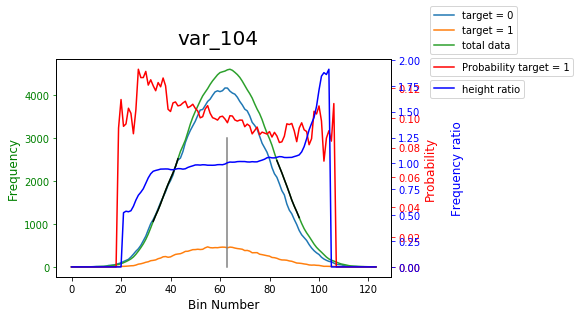

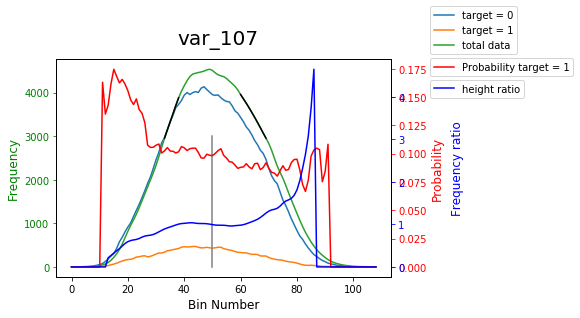

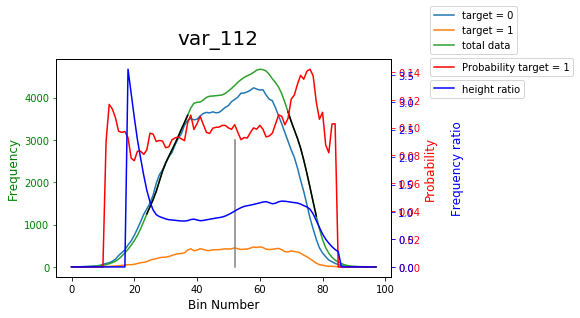

In [10]:
reversed_features = ['var_104', 'var_107', 'var_112', 'var_121', 'var_14', 'var_140', 'var_142', 'var_149', 'var_156', 'var_160', 'var_172', 'var_177', 'var_178', 'var_186', 'var_192', 'var_199', 'var_20', 'var_21', 'var_23', 'var_31', 'var_33', 'var_45', 'var_57', 'var_65', 'var_77', 'var_8', 'var_87']
for var in reversed_features[:3]:
    plot_graph(var, train_df, Hmin = 80)

### **3.3) FLAT FEATURES EXAMPLE**

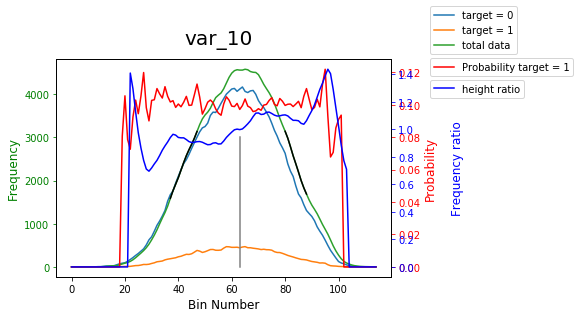

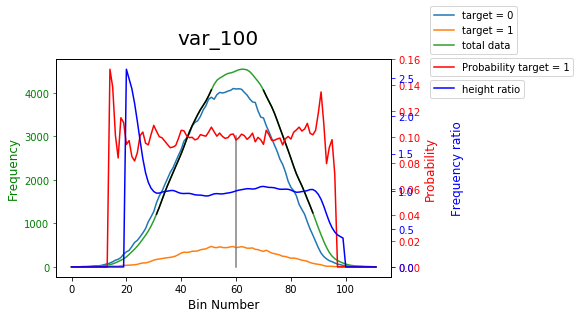

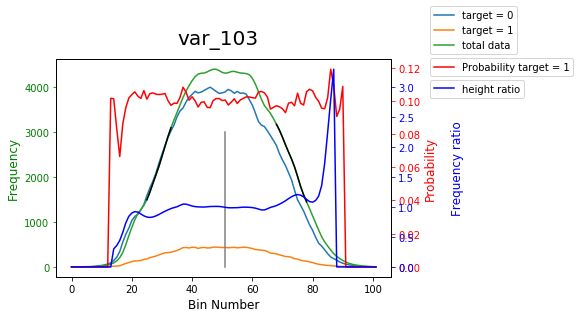

In [11]:
flat_features = ['var_10', 'var_100', 'var_103', 'var_117', 'var_124', 'var_126', 'var_136', 'var_158', 'var_161', 'var_17', 'var_183', 'var_185', 'var_27', 'var_29', 'var_30', 'var_38', 'var_41', 'var_47', 'var_7', 'var_98']
for var in flat_features[:3]:
    plot_graph(var, train_df, Hmin = 80)

### **3.4) EXTREME FEATURES EXAMPLE**

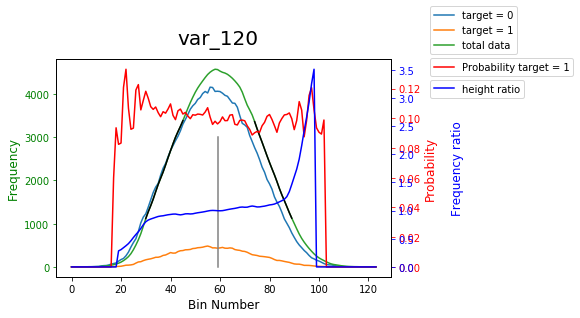

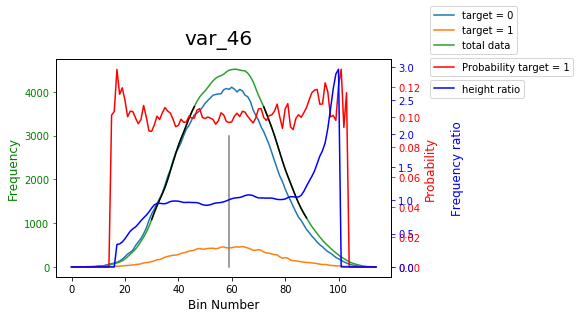

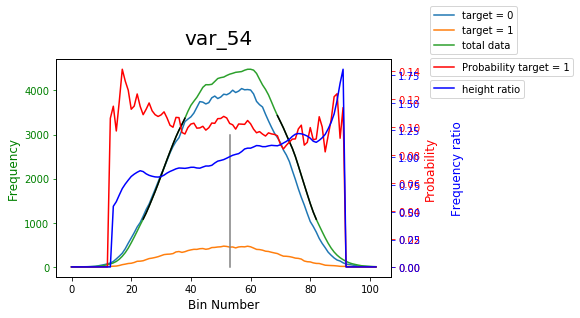

In [12]:
extreme_features = ['var_120', 'var_46', 'var_54', 'var_58']
for var in extreme_features[:3]:
    plot_graph(var, train_df, Hmin = 80)

### **4) FEATURE ENGINEERING**

#### **4.1) USING FREQUENCY RATIO AS A PREDICTIVE SCORE**
Based on this correlation between frequency ratio and probability of making a transfer, I gave to each client on each variable a score indicating the probability of making a transfer. Then, I summed this score and compared to the target. The final result was a new feature with 0.43 correlation with the target. The higher the score, the higher were the chances of making a transfer. <br>
*Note: I won't get in details on how I did it, but if you want to know, let me know on the comments.*

Besides the high correlation, my prediction score stayed about the same. I would guess that I wasn't adding any new information to the model that it didn't already know.

However, I didn't give up as I had a last idea to try.

#### **4.2) SEPARATING DIFFERENT POPULATIONS AS A GAUSSIAN MIXTURE**

If you look closely at the variables, you can easily see that it is possible to identify a mixture of distributions, like if there were different populations. Take a look, for example, at the right side of the 4, 5 and 26 distribution.


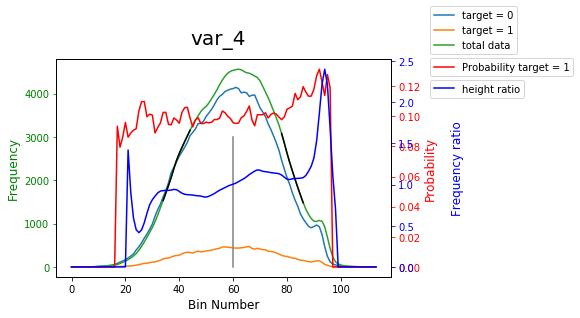

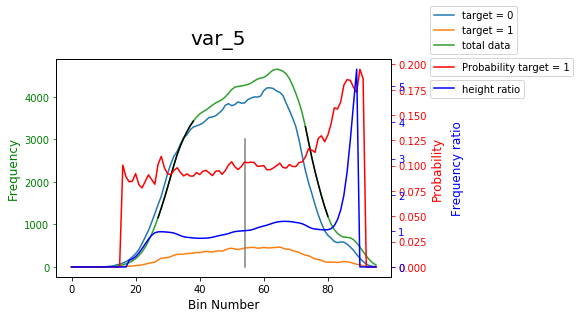

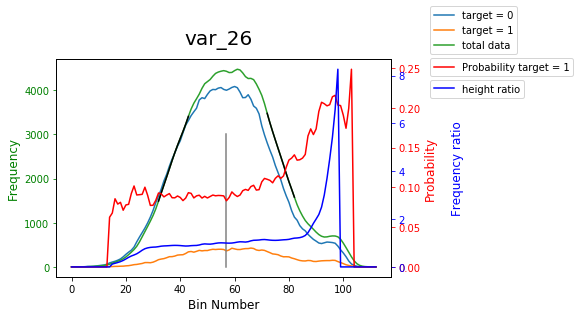

In [13]:
for var in ['var_4', 'var_5', 'var_26']:
    plot_graph(var, train_df, Hmin = 80)

All of these variables have a bump of frequency that matches the rising of the probability of making a transfer. If we separate those populations, maybe each one of them could be a different variable, and our algorithm would be able to identify better who is going to make a transfer. I won't get into details on how I approached that, but you can see what I mean by a simple example below.

In [14]:
from itertools import starmap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import mlab
from scipy.stats import truncnorm
from sklearn.mixture import GaussianMixture

var_4


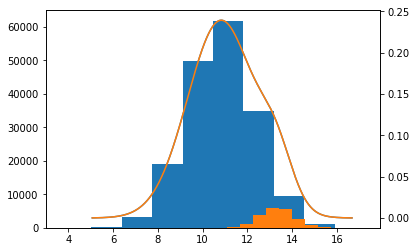

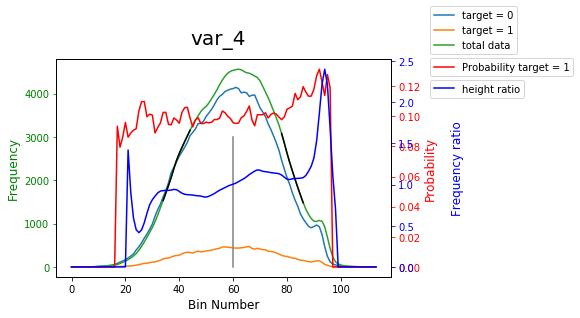

In [15]:
#EXAMPLE VARIABLE 4
mydf = train_df
var = 'var_4'
print(var)

n_components = 2
mydf.sort_values(var, inplace = True)
samples = np.array(mydf[var])
samples_max = max(samples)
samples_min = min(samples)


mixture = GaussianMixture(n_components=n_components, weights_init = [0.80, 0.20], means_init = [[11], [14.5]]).fit(samples.reshape(-1, 1))
means_hat = mixture.means_.flatten()
weights_hat = mixture.weights_.flatten()
sds_hat = np.sqrt(mixture.covariances_).flatten()


means_hat = [m for m, _ in sorted(zip(means_hat, sds_hat))]
sds_hat = [s for _, s in sorted(zip(means_hat, sds_hat))]

#print('mixture converged', mixture.converged_)
#print('means', means_hat)
#print('standard deviations', sds_hat)
#print('weights', weights_hat)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for mu1_h, sd1_h, weight, i in zip(means_hat, sds_hat, weights_hat, range(n_components)):

    x_axis = np.linspace(samples_min, samples_max, int(np.round(weight*len(samples))))

    Y = np.random.normal(mu1_h, sd1_h, int(np.round(weight*len(samples))))
    Y = np.exp(mixture.score_samples(x_axis.reshape(-1,1)))
    ax2.plot(x_axis, Y)
    ax1.hist(np.random.normal(mu1_h, sd1_h, int(np.round(weight*len(samples)))))

    mydf[var+'_' + str(i)] = np.nan

mydf.sort_values('ID_code', inplace = True)
plt.show

plot_graph('var_4', train_df, Hmin = 80)

Unfortunatelly, I also wasn't sucessful with this feature engineering approach, but maybe I just didn't try it the right way.

### **5) SUMMARY**

We proved that there is a correlation between making a transfer and the frequency ratio of the two sides of the distribution. We hypothesized that maybe it is possible to separate different populations from each variable and create new features from this information.

I hope you had fun reading this kernel. Please, if it gave you new ideas or if you learned something new about the data, consider upvoting, and let me know on the comments if you have succeeded implementing them.
